# **Shatnawi Paper Data Preprocessing**

https://www.sciencedirect.com/science/article/pii/S2666521224000553#

In [1]:
!pip install pynrrd
!pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 7.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import random
import albumentations as A
import pandas as pd
import nrrd
import os
import matplotlib.pyplot as plt
import cv2 
from scipy.signal import correlate2d
from collections import Counter
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.1' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def read_lung_cancer_data(
    excel_path='/kaggle/input/lung-cancer/AI Project 2024-2025-20241230T231658Z-001/AI Project 2024-2025/dataset_lung.xlsx',
    images_dir='/kaggle/input/lung-cancer/AI Project 2024-2025-20241230T231658Z-001/AI Project 2024-2025/Train'
):
    # Load the Excel file
    data = pd.read_excel(excel_path)
    
    # List to store all samples
    dataset = []

    # Iterate through the rows of the Excel file
    for _, row in data.iterrows():
        full_slice_path = os.path.join(images_dir, row['Full_slice'])
        nodule_path = os.path.join(images_dir, row['Nodule'])
        label = row['TumorClass']
        
        # Read the .nrrd files
        full_slice_data, _ = nrrd.read(full_slice_path)
        nodule_data, _ = nrrd.read(nodule_path)
        
        full_slice_data = np.expand_dims(full_slice_data, axis=-1)
        nodule_data = np.expand_dims(nodule_data, axis=-1)
        
        # Append the structured data
        dataset.append({
            'full_slice': full_slice_data,
            'nodule': nodule_data,
            'label': label
        })
    
    return dataset

In [4]:
# Read the lung cancer data
dataset = read_lung_cancer_data()

# Normalize the images in the dataset
for sample in dataset:
    sample['full_slice'] = (sample['full_slice'] - np.min(sample['full_slice'])) / (np.max(sample['full_slice']) - np.min(sample['full_slice']))
    sample['nodule'] = (sample['nodule'] - np.min(sample['nodule'])) / (np.max(sample['nodule']) - np.min(sample['nodule']))

/tmp/ipykernel_10/2691318670.py:6: RuntimeWarning: overflow encountered in scalar subtract
  sample['full_slice'] = (sample['full_slice'] - np.min(sample['full_slice'])) / (np.max(sample['full_slice']) - np.min(sample['full_slice']))


In [5]:
def plot_image(image, title='Image'):
    """
    Plots a given image using matplotlib.

    Args:
        image (numpy.ndarray): The image to plot.
        title (str): The title of the plot.
    """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

## Pipeline sample

In [6]:
img = dataset[0]['full_slice']
img = (img * 255).astype(np.uint8)

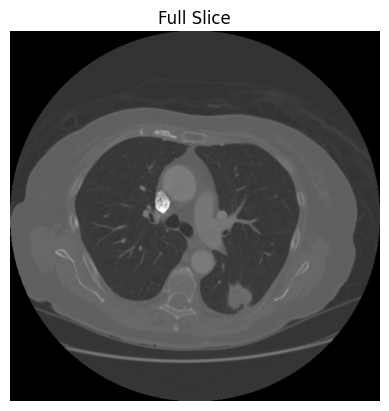

In [7]:
# Original
plot_image(img, title='Full Slice')

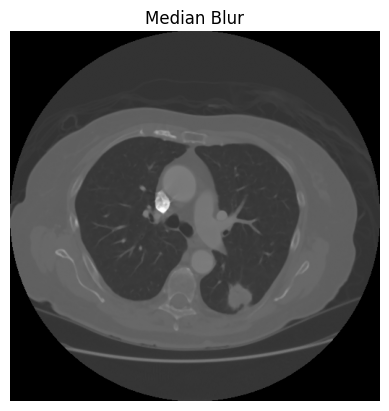

In [8]:
median_blur_img = cv2.medianBlur(img, 3)
plot_image(median_blur_img, title='Median Blur')

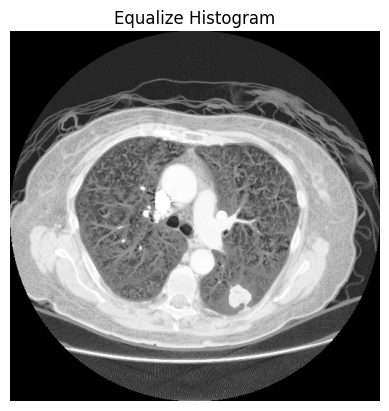

In [9]:
equalize_hist_img = cv2.equalizeHist(img)
plot_image(equalize_hist_img, title='Equalize Histogram')

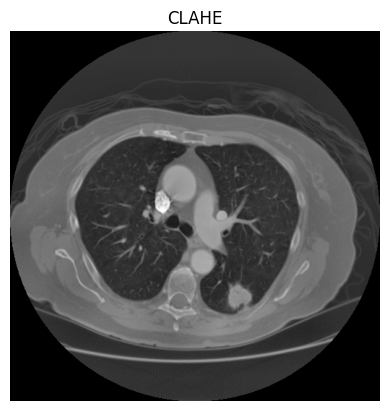

In [10]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img)
plot_image(clahe_img, title='CLAHE')

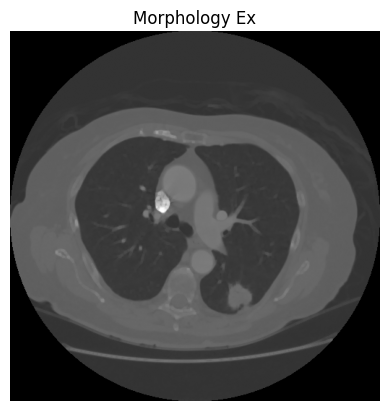

In [11]:
kernel = np.ones((3, 3), np.uint8)
morphology_ex_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
plot_image(morphology_ex_img, title='Morphology Ex')

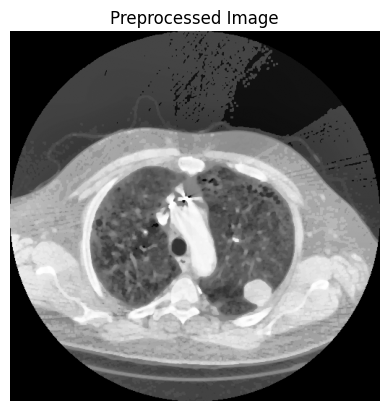

In [12]:
# All together
def img_preprocessing(img):
    img = cv2.medianBlur(img, 3)
    img = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    kernel = np.ones((3, 3), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img

img = dataset[202]['full_slice']
img = (img * 255).astype(np.uint8)
preprocessed_img = img_preprocessing(img)
plot_image(preprocessed_img, title='Preprocessed Image')


In [13]:
# Apply img_preprocessing to all images in the dataset
for sample in dataset:
    sample['full_slice'] = img_preprocessing((sample['full_slice'] * 255).astype(np.uint8))
    sample['nodule'] = img_preprocessing((sample['nodule'] * 255).astype(np.uint8))

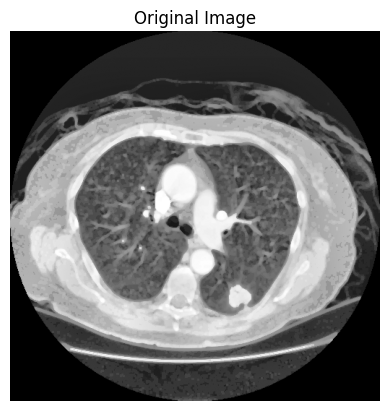

In [14]:
img = dataset[0]['full_slice']
plot_image(img, title='Original Image')

In [15]:
# Convert grayscale images to RGB in the validation set
for sample in dataset:
    sample['full_slice'] = cv2.cvtColor(sample['full_slice'], cv2.COLOR_GRAY2RGB)
    sample['nodule'] = cv2.cvtColor(sample['nodule'], cv2.COLOR_GRAY2RGB)

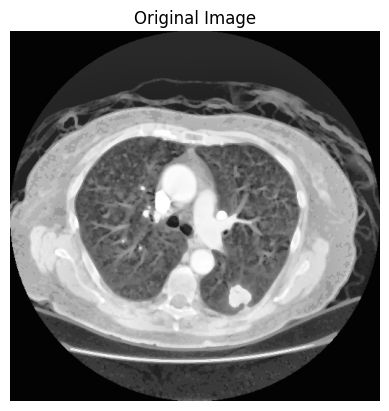

In [16]:
img = dataset[0]['full_slice']
plot_image(img, title='Original Image')

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# Extract labels
labels = [sample['label'] for sample in dataset]

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.13, random_state=42)

# Split the dataset into training+validation and test sets
for train_val_index, test_index in sss.split(dataset, labels):
    train_val_set = [dataset[i] for i in train_val_index]
    test_set = [dataset[i] for i in test_index]

# Extract labels for the training+validation set
train_val_labels = [sample['label'] for sample in train_val_set]

# Further split the training+validation set into training and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, val_index in sss.split(train_val_set, train_val_labels):
    train_set = [train_val_set[i] for i in train_index]
    val_set = [train_val_set[i] for i in val_index]

# Print the sizes of the datasets
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 1746
Validation set size: 309
Test set size: 308


## Augmentations for Trainning

In [18]:
def augmentation(image):
    transform = A.Compose([
        A.Rotate(limit=30, p=0.5),  # Random Rotation
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),  # Combined shift, scale, rotate
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ])
    
    return transform(image=image)['image']

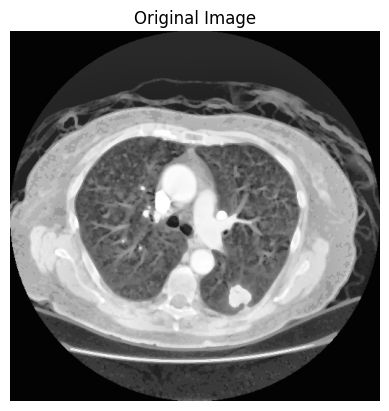

In [19]:
img = dataset[0]['full_slice']
plot_image(img, title='Original Image')

/usr/local/lib/python3.10/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_10/3988027350.py:5: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


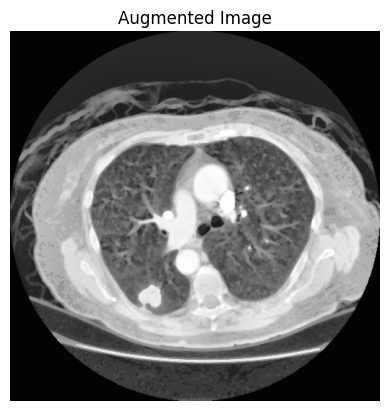

In [20]:
augmented_img = augmentation(img)
plot_image(augmented_img, title='Augmented Image')

In [21]:
# from collections import Counter
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm

# # Count the occurrences of each label in the training set
# label_counts = Counter([sample['label'] for sample in train_set])

# # Determine the maximum count of any label
# max_count = max(label_counts.values())

# # Function to create augmented samples for a single sample
# def create_augmentations(sample, num_augmentations):
#     augmented_samples = []
#     for _ in range(num_augmentations):
#         augmented_sample = {
#             'full_slice': augmentation(sample['full_slice']),
#             'nodule': augmentation(sample['nodule']),
#             'label': sample['label']
#         }
#         augmented_samples.append(augmented_sample)
#     return augmented_samples

# # Use ThreadPoolExecutor to parallelize the augmentation process
# augmented_train_set = []
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for sample in train_set:
#         label = sample['label']
#         count = label_counts[label]
        
#         # Add the original sample
#         augmented_train_set.append(sample)
        
#         # Determine the number of augmentations needed
#         num_augmentations = max_count - count
#         if num_augmentations > 0:
#             # Submit the augmentation task to the executor
#             futures.append(executor.submit(create_augmentations, sample, num_augmentations))
    
#     # Collect the results as they complete
#     for future in tqdm(as_completed(futures), total=len(futures), desc="Augmenting dataset"):
#         augmented_train_set.extend(future.result())

# # Update the train_set with the augmented samples
# train_set = augmented_train_set

# # Print the new sizes of the datasets
# print(f"Training set size after augmentation: {len(train_set)}")
# print(f"Validation set size: {len(val_set)}")
# print(f"Test set size: {len(test_set)}")


In [22]:
# Count the occurrences of each label in the training set
label_counts = Counter([sample['label'] for sample in train_set])

# Determine the maximum count of any label
max_count = max(label_counts.values())

# Create augmented copies of each sample
augmented_train_set = []
augmentations = [2, 1, 0, 1, 3]

for sample in tqdm(train_set, desc="Augmenting dataset"):
    label = sample['label']
    count = label_counts[label]
    
    # Add the original sample
    augmented_train_set.append(sample)
    
    # Determine the number of augmentations needed
    num_augmentations = augmentations[label-1]
    
    # Create augmented copies
    for _ in range(num_augmentations):
        augmented_sample = {
            'full_slice': augmentation(sample['full_slice']),
            'nodule': augmentation(sample['nodule']),
            'label': label
        }
        augmented_train_set.append(augmented_sample)

# Update the train_set with the augmented samples
train_set = augmented_train_set

# Print the new sizes of the datasets
print(f"Training set size after augmentation: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Augmenting dataset:   0%|          | 0/1746 [00:00<?, ?it/s]/tmp/ipykernel_10/3988027350.py:5: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
Augmenting dataset: 100%|██████████| 1746/1746 [00:12<00:00, 135.64it/s]


Training set size after augmentation: 3089
Validation set size: 309
Test set size: 308


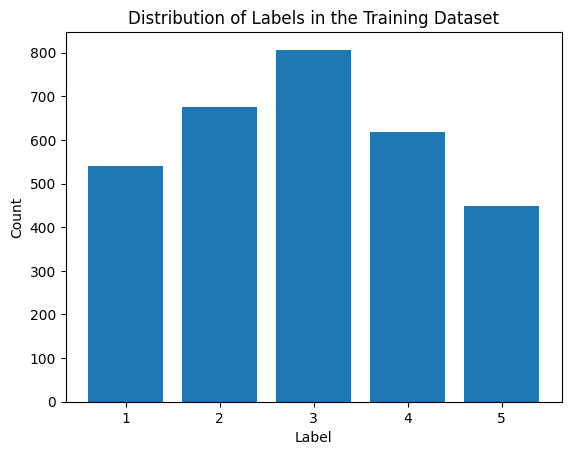

In [23]:
# Count the occurrences of each label in the training set
label_counts = Counter([sample['label'] for sample in train_set])

# Plot the distribution of labels
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Training Dataset')
plt.show()

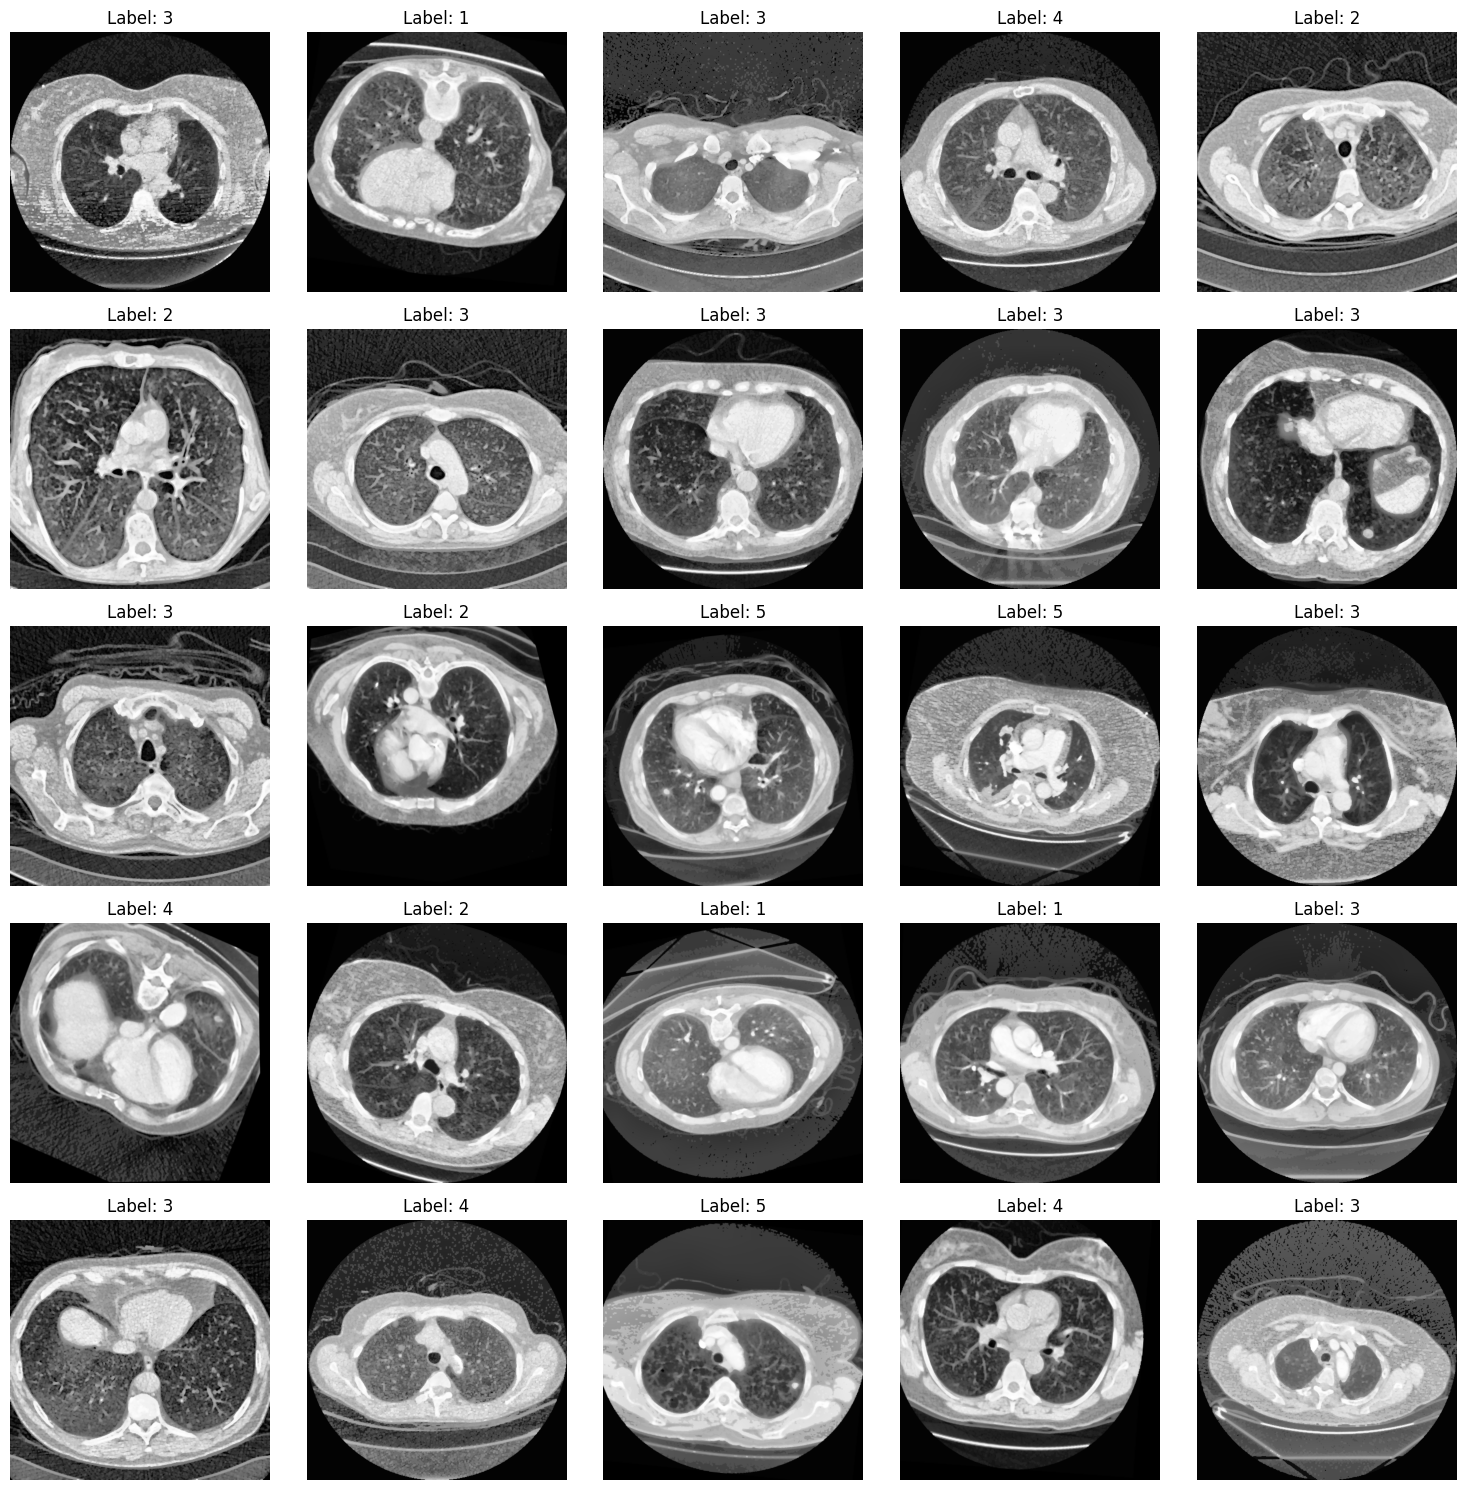

In [27]:
# Select 25 random samples from the training dataset
random_samples = random.sample(train_set, 25)

# Plot the selected samples
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, sample in enumerate(random_samples):
    axes[i].imshow(sample['full_slice'], cmap='gray')
    axes[i].set_title(f"Label: {sample['label']}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [36]:
def pad_image(image, target_shape=(138, 138)):
    """
    Pads an image to the target shape with black borders while keeping the original image
    in the top-left corner. Returns the padded image along with the bounding box.
    """
    current_rows, current_cols, current_channels = image.shape
    
    # Calculate padding for the bottom and right sides
    pad_bottom = target_shape[0] - current_rows
    pad_right = target_shape[1] - current_cols
    
    # Pad the image (top-left corner remains untouched)
    padded_image = np.zeros((target_shape[0], target_shape[1], 3), dtype=image.dtype)
    for c in range(current_channels):
        channel = image[:, :, c]
        padded_image[:current_rows, :current_cols, c] = channel
    
    # Bounding box coordinates (top-left corner with original image dimensions)
    bbox = (0, 0, current_rows, current_cols)  # (top, left, height, width)
    
    return padded_image

In [37]:
# Pad all nodule images in the training, test, and validation sets
for dataset in [train_set, val_set, test_set]:
    for sample in dataset:
        sample['nodule'] = pad_image(sample['nodule'])

In [38]:
def convert_to_numpy(dataset):
    full_slices = np.array([sample['full_slice'] for sample in dataset])
    nodules = np.array([sample['nodule'] for sample in dataset])
    labels = np.array([sample['label'] for sample in dataset])
    return full_slices, nodules, labels

# Convert the training, validation, and test sets
train_full_slices, train_nodules, train_labels = convert_to_numpy(train_set)
val_full_slices, val_nodules, val_labels = convert_to_numpy(val_set)
test_full_slices, test_nodules, test_labels = convert_to_numpy(test_set)

# Print the shapes of the resulting arrays
print(f"Training set shapes: {train_full_slices.shape}, {train_nodules.shape}, {train_labels.shape}")
print(f"Validation set shapes: {val_full_slices.shape}, {val_nodules.shape}, {val_labels.shape}")
print(f"Test set shapes: {test_full_slices.shape}, {test_nodules.shape}, {test_labels.shape}")

Training set shapes: (3089, 512, 512, 3), (3089, 138, 138, 3), (3089,)
Validation set shapes: (309, 512, 512, 3), (309, 138, 138, 3), (309,)
Test set shapes: (308, 512, 512, 3), (308, 138, 138, 3), (308,)


In [39]:
# Save the training, validation, and test sets in compressed .npz files
np.savez_compressed('train_set.npz', full_slices=train_full_slices, nodules=train_nodules, labels=train_labels)
np.savez_compressed('val_set.npz', full_slices=val_full_slices, nodules=val_nodules, labels=val_labels)
np.savez_compressed('test_set.npz', full_slices=test_full_slices, nodules=test_nodules, labels=test_labels)